In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

from cart import MyEnv
#from q_learning import Q_learning
from qpth.qp import QPFunction

%matplotlib inline

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from qpth.qp import QPFunction


class Q_learning(nn.Module):
    """Builds the strucre of the QPNet.
    
    The struture is x0-QP-[cost,u].
    QP means the optimization problem layer over`nz` variables, 
    having `nineq` inequality constraints and `neq` equality 
    constraints.
    The optimization problem is of the form
        \hat z =   argmin_z 1/2*z^T*Q*z + p^T*z
                subject to G*z <= h
                           F*z = f
    where Q \in S^{nz,nz},
        S^{nz,nz} is the set of all positive semi-definite matrices,
        p \in R^{nz}
        G \in R^{nineq,nz}
        h \in R^{nineq}
        A \in R^{neq,nz}
        b \in R^{neq}
        This layer has Q = L*L^T+ϵ*I where L is a lower-triangular matrix,
        and h = G*z0 + s0, b = A*z0 for some learnable z0 and s0,  
        to ensure the problem is always feasible.
    """
    
    def __init__(self, num_input, num_output, num_u=5, eps=1e-4, cuda=True,collect=False):

        """Initiates OptNet."""
        super().__init__()
        self.num_input = num_input
        self.num_output = num_output
        self.num_u = num_u
        self.eps = eps
        self.cuda = cuda
        self.collect = collect
        
        self.N = int(self.num_u/self.num_output)  # get the number of the finite steps in MPC
        self.num_ineq = 2*(num_u + num_input*self.N)
       
        self.Q = Parameter(2*torch.rand(num_input, num_input),requires_grad=True)
        self.P = Parameter(20*torch.rand(num_input, num_input),requires_grad=True)        
        self.R = Parameter(2*torch.rand(num_output,num_output),requires_grad=True)
        
        self.A = Parameter(2*torch.rand(num_input, num_input),requires_grad=True)
        self.B = Parameter(2*torch.rand(num_input, num_output),requires_grad=True)

        self.s0 = Parameter(10*torch.ones(1,2*num_u),requires_grad=False)
        self.s1 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)
        self.s2 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)

        if collect==True:
            self.Q = Parameter(torch.eye(num_input, num_input),requires_grad=True)
            self.P = Parameter(10*torch.eye(num_input, num_input),requires_grad=True)
            self.R = Parameter(torch.eye(num_output),requires_grad=True)
            self.A = Parameter(torch.Tensor([[1.0,1.0],[0,1.0]]),requires_grad=True)
            self.B = Parameter(torch.Tensor([[0.5],[1.0]]),requires_grad=True)
            self.s0 = Parameter(10*torch.ones(1,2*num_u),requires_grad=False)
            self.s1 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)
            self.s2 = Parameter(4*torch.ones(1,num_input*self.N),requires_grad=False)
        
        
        weight = torch.zeros(num_u)
        weight[0] = 1.0
        self.weight = Parameter(weight,requires_grad=False)
        
        self.F = Parameter(torch.zeros(1,self.num_u),requires_grad=False)
        self.F[0,0] = 1.0
        self.f = Parameter(torch.tensor(1),requires_grad=False)
        self.e = Parameter(torch.Tensor(),requires_grad=False)
            

    def forward(self, x, u0=torch.Tensor()):
        """Builds the forward strucre of the QPNet.
        Sequence: x0-QP-[cost,u].
        """
        x =self.vari_gpu(x)
        u0 =self.vari_gpu(u0)
        
        A_hat = self.build_A_block()
        B_hat = self.build_B_block()
        
        # set up the QP parameters 
        Q = self.Q.mm(self.Q.t())
        P = self.P.mm(self.P.t())
        R = self.R.mm(self.R.t())
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat, Q_diag = self.build_Q_block(Q, P, R, B_hat)
        self.Qr = Q_hat
                
        # linear layer  p = 2 * (Q_diag*B_hat)^T * (A_hat*x0)
        num_batch = x.size(0)
        x0 = x.view(num_batch, -1)
        A_x0 = A_hat.mm(x0.t()).t()  # present[x1;x2;...;xN] size: batch * dim(x1;x2;...;xN)
        p = 2*A_x0.mm(Q_diag.mm(B_hat))
        
        G = self.build_G_block(B_hat)
        s0 = self.s0.repeat(num_batch,1)
        s1 = self.s1.repeat(num_batch,1)
        s1 -= A_x0
        s2 = self.s2.repeat(num_batch,1)
        s2 += A_x0
        h = torch.cat((s0,s1,s2),1)
        
        F = self.e
        f = self.e
        if u0.nelement() != 0:  # for Q(x0,u0), add another constraint: u(0) = u0
            F = self.F
            f = u0.squeeze(0)*self.f
        
        # gets the solution of the basic optimization problem
        u_opt = QPFunction(verbose=-1)(Q_hat, p, G, h, F, f)  # size: batch*dim(u)
        u0_opt = u_opt.mv(self.weight)
        
        # get the optimal cost
        a = (u_opt.mm(Q_hat)*u_opt/2 + p*u_opt).sum(1)
        b = (A_x0.mm(Q_diag)*A_x0).sum(1)
        c = (x0.mm(Q)*x0).sum(1)
        cost_opt = (a+b+c).unsqueeze(1)  # size: batch*1
        # u0_opt = u_opt.mv(self.weight).unsqueeze(1)  # only the fisrt action
        #print(u0,u0_opt)
        return 0.1*cost_opt, u0_opt
    
    def build_A_block(self):
        """
        [A]
        [A^2] 
        [A^3]
        [...]
        """
        N = self.N  # number of MPC steps
        A = self.A
        
        row_list = [A]  # reocrd the every row in B_hat
        
        for i in range(1, N):
            A = A.mm(self.A)
            row_list.append(A)
        return torch.cat(row_list,0)
    
    def build_B_block(self):
        """In MPC, express x vector in u vector and compute the new big B_hat matrix
        [B 0 0 ...
        [AB B 0
        ...
        """

        N = self.N  # number of MPC steps
        row_list = []  # reocrd the every row in B_hat
        
        first_block = self.B
        zero = Variable(torch.zeros(self.num_input, self.num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row= torch.cat([first_block, zero],1)
        row_list.append(row)
        
        for i in range(1, N):
            first_block = self.A.mm(first_block)
            row = torch.cat([first_block, row[:,:self.num_output*(N-1)]],1)
            row_list.append(row)  
            
        return torch.cat(row_list,0)
        
        
    def build_Qdiagnol_block(self, Q, P):
        """ (num_imput*(N-1)) x (num_imput*(N-1))
        The last block is P for x(N)"""
        
        N = self.N  # number of MPC steps
        num_input = self.num_input
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_input, num_input*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, Q, zero],1)  # [0 0 ... Q 0 0 ...]
        for i in range(N, 1, -1):
            row_list.append(row_long[:, (i-1)*num_input : (i+N-1)*num_input])
            
        row = torch.cat([zero, P],1)  # last line by [0 P]
        row_list.append(row)
        
        return torch.cat(row_list,0)
    
    def build_Rdiagnol_block(self, R):
        """
        [R 0 0 ...
        [0 R 0
        ...
        """
        N = self.N  # number of MPC steps
        num_output = self.num_output
        
        row_list = []  # reocrd the every row in B_hat
        zero = Variable(torch.zeros(num_output, num_output*(N-1)))
        zero = self.vari_gpu(zero)
        row_long = torch.cat([zero, R, zero],1)  # [0 0 ... Q 0 0 ...]
        
        for i in range(N, 0, -1):
            row_list.append(row_long[:, (i-1)*num_output : (i+N-1)*num_output])
        return torch.cat(row_list,0)
        
    def build_Q_block(self, Q, P, R, B_hat):
        """Build the Q_hat matrix so that MPC is tranfered into basic optimization problem
        1/2*Q_hat = B_hat^T * diag(Q) * B_hat + diag(R)
        """
        
        Q_diag = self.build_Qdiagnol_block(Q,P)
        R_diag = self.build_Rdiagnol_block(R)
        Q_hat = B_hat.t().mm(Q_diag.mm(B_hat)) + R_diag
        return 2*Q_hat,Q_diag 
        
        
    def build_G_block(self,B_hat):
        """Build the G matrix so that MPC is tranfered into basic optimization problem
        G = [eye(num_u)]
            [   B_hat  ]
            [-eye(num_u)]
            [  -B_hat  ]
        """
        
        eye = Variable(torch.eye(self.num_u))
        eye = self.vari_gpu(eye)
        G = torch.cat((eye, -eye, B_hat, -B_hat), 0)
        # print(self.B_hat)
        # print(G.size())
        return G
    
    def vari_gpu(self, var):
        if self.cuda:
            var = var.cuda()
            
        return var

    def act(self, state, epsilon, env):
        """The action excuted by epsilon-greedy exploration
        """
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state)).unsqueeze(0) # adds extra dim when single input
            state = self.vari_gpu(state)
            _, u_opt = self.forward(state)
            action = (u_opt.cpu().detach().numpy())  # compute the u*[0] 
            #print('act:q_value ',q_value)
            #print('act:model action ',action)
        else:
            rand = np.random.rand(int(np.array(env.action_space.shape)))
            high = env.action_space.high
            low = env.action_space.low
            action = low + rand*(high-low)
            #print('act: ',action)
        return action


In [10]:
from collections import namedtuple

# a named tuple representing a single transition in our environment. 
# It essentially maps (state, action) pairs to their (next_state, reward)
# result, with the state being the screen difference 
Transition = namedtuple('Transition',
                        ('state_', 'action_', 'next_state_', 'reward_', 'done_'))


class ReplayMemory(object):
    ''' a cyclic buffer of bounded size that holds the 
    transitions observed recently. 
    '''
    def __init__(self, capacity):
        self.capacity = capacity  # largest # memory
        self.memory = []
        self.position = 0  # count length of memory

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  # sample a batch from the buffer

    def __len__(self):
        return len(self.memory)

In [11]:
def train_ch(policy_net,target_net,memory,batch_size,gamma,loss_fun,optimizer):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    state = torch.cat(batch.state_)
    action = torch.cat(batch.action_)
    next_state = torch.cat(batch.next_state_)
    reward = torch.cat(batch.reward_)
    done = torch.cat(batch.done_)

    q_value, _ = policy_net(state,action)  # Q(x0,u0)
    v_value, _ = target_net(next_state)  # V(x1)

    # compute the expected Q values
    expected_q_value = reward + gamma * v_value * (1-done)

    # compute loss
    loss = loss_fun(expected_q_value, q_value) 
    
    # optimize the model  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data

# Epsilon-greedy exploration
# The epsilon decreases exponetially as time goes by.
def greedy_epsilon(epoch):
    epsilon_start = 0.8
    epsilon_final = 0.01
    epsilon_decay = 500
    epsilon = epsilon_final + (epsilon_start-epsilon_final) * math.exp(-1.*epoch/epsilon_decay)
    return epsilon

#  Initiate the model

In [12]:
cuda = False
model = Q_learning(num_input=2, num_output=1, num_u=5, cuda=cuda,collect=False) 
device = torch.device("cuda:0" if cuda else "cpu")
model = model.to(device)
target_net = Q_learning(num_input=2, num_output=1, num_u=5, cuda=cuda).to(device)
target_net.load_state_dict(model.state_dict())
target_net.eval()
TARGET_UPDATE = 10

loss_fun = torch.nn.MSELoss()  # Initializes the loss function
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Initializes the optimizer

env = MyEnv()
gamma = 1.0
batch_size = 20
memory = ReplayMemory(10000)

state = env.reset()
losses = []
trac_time = []
trac_reward = []
step_total = 0  # records total steps for all trajectories
TD_error = [] # records target difference error

if cuda:  # cuda or cpu
    Var = lambda *args, **kwargs: \
        torch.autograd.Variable(*args, **kwargs).cuda()  # Variable: not require gra
else:
    Var = lambda *args, **kwargs: \
        torch.autograd.Variable(*args, **kwargs)

# Train the model

In [13]:
# record model parameter 
A3 = []
A1 = []
A2 = []
A4 = []
Q3 = []
Q1 = []
Q2 = []
Q4 = []
B1 = []
B2 = []

In [14]:
# from instructor import Instructor
# instructor = Instructor(model, optimizer, loss_fun)


# train the data

for epoch in range(300):  # First loop: number of the trajectory
                               
    #env.close()  # restart a new trajectory
    state = env.reset()
    done = False  # records whether one trajectory is finished
    t_traj = 0  # records the number of steps in one trajectory
    r_traj = 0  # records the total rewards in one trajectory
   
    while not done:  # Second loop: within one tractory

#         position = str(env.state[0].round(decimals=2))
#         velocity = str(env.state[1].round(decimals=2))
        text = 'trajectory: '+str(epoch+1)
        env.render(text)  # visualization of the cart position 
        epsilon = greedy_epsilon(step_total)
        action = model.act(state, epsilon,env)

        if action[0]>10.0 or action[0]<-10.0:  # if infeasible, start a new trajectory
            break
        
        next_state, reward, done, _ = env.step(action,t_traj)
        
        # if done, the cart may go out of contraints, we don't 
        # want this fake reward to be saved.
#         if done:
#             break

        # save the step in the memory
        # transfer into type tensor
        state_      = Var(torch.FloatTensor(state)).unsqueeze(0)
        next_state_ = Var(torch.FloatTensor(next_state)).unsqueeze(0)
        action_     = Var(torch.FloatTensor(action)).unsqueeze(0)
        reward_     = Var(torch.FloatTensor([reward])).unsqueeze(0)
        done_       = Var(torch.FloatTensor([done])).unsqueeze(0)
        
        memory.push(state_, action_, next_state_, reward_, done_)
        state = next_state
        t_traj += 1
        r_traj += reward
        
        
        # Third loop: train the model
        loss = 0.0
        if step_total>batch_size:
            for k in range(3):
                loss += train_ch(model,target_net,memory,batch_size,gamma,loss_fun,optimizer)
                losses.append(loss/(k+1))
        
        # update the target network
        step_total += 1
        if step_total % TARGET_UPDATE == 0:  
            target_net.load_state_dict(model.state_dict())

        if (step_total)%100 == 0 and step_total>128:
            print('[step_total: %d] training loss: %.3f' %
                              (step_total, losses[step_total]))
        
        # compute the target difference error
        q_value, _ = model(state_,action_)  # Q(x0,u0)
        v_value, _ = target_net(next_state_)  # V(x1)
        q_value = q_value.data[0,0].cpu().numpy()
        v_value = v_value.data[0,0].cpu().numpy()
        TD_error.append(reward + gamma * v_value * (1-done) - q_value)
        
        A = model.A*1.0
        B = model.B*1.0
        Q = model.Q.mm(model.Q.t())
        
        A1.append(A[0,0])
        A2.append(A[0,1])
        A3.append(A[1,0])
        A4.append(A[1,1])
        
        B1.append(B[0])
        B2.append(B[1])
        
        Q1.append(Q[0,0])
        Q2.append(Q[0,1])
        Q3.append(Q[1,0])
        Q4.append(Q[1,1])        

    #  record data of this trajectory in lists
    trac_time.append(t_traj)
    trac_reward.append(r_traj)


        
env.close()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/season/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-970aa9560e7a>", line 22, in <module>
    action = model.act(state, epsilon,env)
  File "<ipython-input-9-8d5380b5165d>", line 247, in act
    _, u_opt = self.forward(state)
  File "<ipython-input-9-8d5380b5165d>", line 119, in forward
    u_opt = QPFunction(verbose=-1)(Q_hat, p, G, h, F, f)  # size: batch*dim(u)
  File "/home/season/anaconda3/lib/python3.7/site-packages/qpth/qp.py", line 96, in forward
    eps, verbose, notImprovedLim, maxIter)
  File "/home/season/anaconda3/lib/python3.7/site-packages/qpth/solvers/pdipm/batch.py", line 105, in forward
    dual_resid = torch.norm(rx, 2, 1).squeeze()
  File "/home/season/anaconda3/lib/python3.7/site-packages/torch/functional.py", line 698, in norm
    return torch._C._VariableFunctions.norm(input, p, dim, kee

KeyboardInterrupt: 

In [15]:
env.close()

Text(0.5, 0, 'tractory sequence')

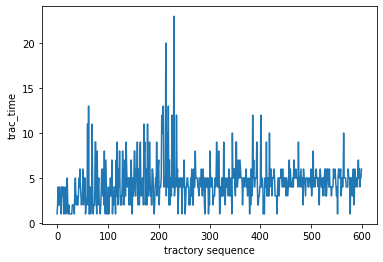

In [18]:
plt.plot(trac_time)
plt.ylabel('trac_time')
plt.xlabel('tractory sequence')

Text(0.5, 0, 'tractory sequence')

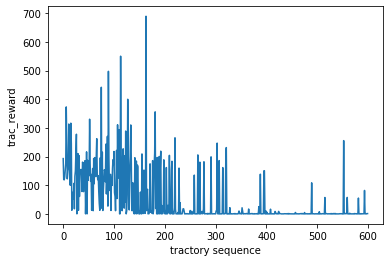

In [19]:
plt.plot(trac_reward)
plt.ylabel('trac_reward')
plt.xlabel('tractory sequence')

Text(0.5, 0, 'transition step')

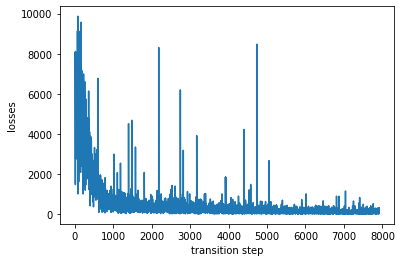

In [25]:
plt.plot(np.array(losses_change))
plt.ylabel('losses')
plt.xlabel('transition step')

Text(0.5, 0, 'tractory sequence')

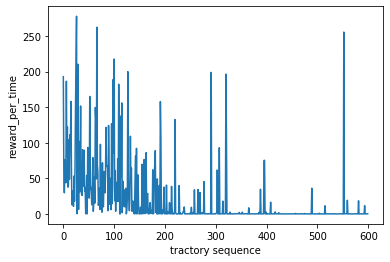

In [27]:
plt.plot(np.array(trac_reward)/np.array(trac_time))
plt.ylabel('reward_per_time')
plt.xlabel('tractory sequence')

Text(0.5, 0, 'A1')

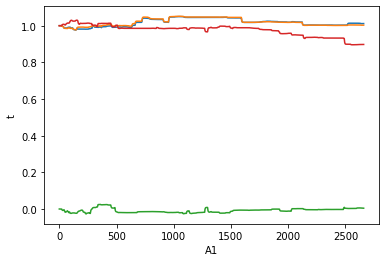

In [28]:
plt.plot(A1)
plt.plot(A2)
plt.plot(A3)
plt.plot(A4)
plt.ylabel('t')
plt.xlabel('A1')

Text(0.5, 0, 'A1')

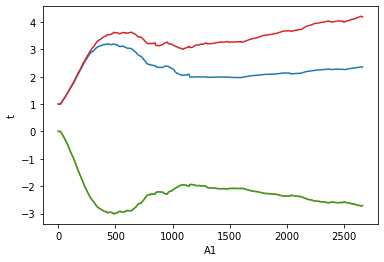

In [29]:
plt.plot(Q1)
plt.plot(Q2)
plt.plot(Q3)
plt.plot(Q4)
plt.ylabel('t')
plt.xlabel('A1')

Text(0.5, 0, 'A1')

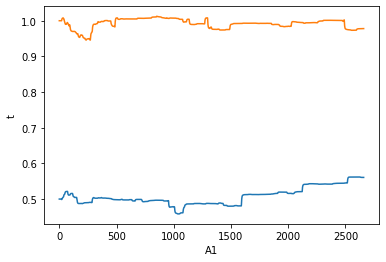

In [30]:
plt.plot(B1)
plt.plot(B2)

plt.ylabel('t')
plt.xlabel('A1')

#  3D MPC solution

In [31]:
npzfile=np.load('./double_integrator_P=10.npz') 
x0 = npzfile['x'] 
c_u = npzfile['cost_u'] 
print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)

shape of x0: (6561, 2)  |shape of [cost, u]: (6561, 6)


shape of x0: (6561, 2)  |shape of [cost, u]: (6561, 6)
Example, x: tensor([-4., -4.], device='cuda:0')  |cost_u[0]: tensor([14.4348,  7.1677, -3.0112, -0.4563,  0.0437,  0.1140], device='cuda:0')
pre:  torch.Size([6561])


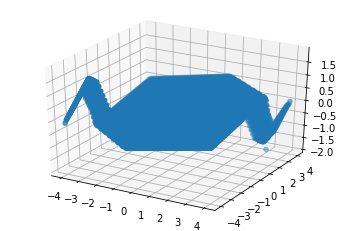

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

print("shape of x0:",x0.shape," |shape of [cost, u]:",c_u.shape)
X1 = x0[:,0]
X2 = x0[:,1]
U0 = c_u[:,1]

x = Variable(torch.from_numpy(x0).float(), requires_grad=False).cuda()
y = Variable((torch.from_numpy(c_u[:,:])).float(), requires_grad=False).cuda()
print("Example, x:", x[0], " |cost_u[0]:",y[0,:])
model.eval()
with torch.no_grad():
    _, out_pre = model(x)
    print('pre: ',out_pre.size())
U0_pre = out_pre.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, U0-U0_pre,cmap=cm.coolwarm)
# ax.scatter(X1, X2,U0_pre )


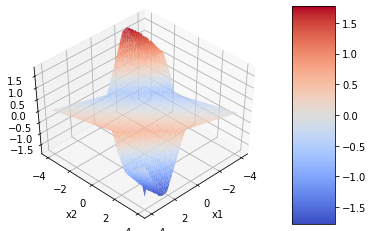

In [34]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(X1, X2, U0-U0_pre,cmap=cm.coolwarm )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')
# Customize the z axis.
#ax.set_zlim(-2, 2)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(elev=45,azim=45)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=1, aspect=5)

plt.show()

Text(0.5, 0, 'u0  ')

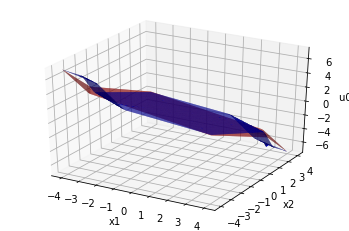

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X1, X2, U0,color="b")
ax.plot_trisurf(X1, X2, U0_pre,color="r" )
plt.ylabel('x2')
plt.xlabel('x1')
ax.set_zlabel('u0  ')


# Save the model

In [55]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [78]:
A = [A1,A2,A3,A4]
Q = [Q1,Q2,Q3,Q4]
B = [B1,B2]

In [96]:
save_checkpoint({
    'step_total': step_total,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'trac_reward':trac_reward,
    'trac_time':trac_time,
    'losses':losses,
    'A':A,
    'B':B,
    'Q':Q,
    'memory':memory
})

In [27]:
import os
resume = 'checkpoint.pth.tar'
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        step_total = checkpoint['step_total']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        trac_reward = checkpoint['trac_reward']
        trac_time = checkpoint['trac_time']
        losses = checkpoint['losses']
        A = checkpoint['A']
        B = checkpoint['B']
        Q = checkpoint['Q']
        memory = checkpoint['memory']

    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

=> loading checkpoint 'checkpoint.pth.tar'
